In [1]:
!pip install super-gradients

In [2]:
!pip install datasets roboflow pybboxes pillow pyyaml scikit-learn

  Using cached datasets-3.0.1-py3-none-any.whl.metadata (20 kB)
  Using cached roboflow-1.1.47-py3-none-any.whl.metadata (9.7 kB)
  Using cached pybboxes-0.1.6-py3-none-any.whl.metadata (9.9 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.17-py310-none-any.whl.metadata (7.2 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
Using cached datasets-3.0.1-py3-none-any.whl (471 kB)
Using cached robof

In [1]:
import torch
import os
import shutil
import zipfile
import json
import random
import yaml
from PIL import Image
from roboflow import Roboflow
from sklearn.model_selection import train_test_split
import pybboxes as pbx
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from getpass import getpass

from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models


from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer

from IPython.display import clear_output


The console stream is logged into /root/sg_logs/console.log


[2024-10-04 09:34:54] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!git clone https://github.com/Jozefov/mAP.git

fatal: destination path 'mAP' already exists and is not an empty directory.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
base_dir = '/content/YoloNAS_Project/'
os.makedirs(base_dir, exist_ok=True)

In [6]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [7]:
def download_huggingface_dataset(save_dir):
    """
    Downloads the Hugging Face dataset and organizes it into images and labels directories.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Load the dataset
    ds = load_dataset("keremberke/forklift-object-detection", name="full")

    # Create directories for each split
    for split in ds.keys():
        split_path = os.path.join(save_dir, split)
        images_path = os.path.join(split_path, 'images')
        labels_path = os.path.join(split_path, 'labels')
        os.makedirs(images_path, exist_ok=True)
        os.makedirs(labels_path, exist_ok=True)

        # Process each example in the split
        for example in ds[split]:
            # Download and save the image
            image_url = example['image']
            image_filename = os.path.basename(image_url)
            image_path = os.path.join(images_path, image_filename)
            if not os.path.exists(image_path):
                !wget -q {image_url} -O {image_path}

            # Save annotations
            annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(labels_path, annotation_filename)
            with open(label_path, 'w') as f:
                for obj in example['objects']:
                    class_id = obj['category_id'] - 1  # Assuming category_id starts at 1
                    bbox = obj['bbox']  # [x, y, width, height]
                    # YOLO format requires normalized coordinates, which we'll handle later
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    print(f"Hugging Face dataset downloaded and saved to {save_dir}")

In [ ]:
# # Define the path to save the Hugging Face dataset
# hf_save_dir = os.path.join(base_dir, 'huggingface_forklift')
# download_huggingface_dataset(hf_save_dir)

## Roboflow dataset

In [8]:
def download_roboflow_datasets(api_key, save_dir):
    """
    Downloads multiple Roboflow datasets and organizes them into separate directories.
    """
    rf = Roboflow(api_key=api_key)

    # Define datasets to download
    roboflow_datasets = [
        {
            "workspace": "hitsz",
            "project": "forklift-and-human",
            "version": "2"  # Changed to version 2 as per your working code
        },
        {
            "workspace": "paft",
            "project": "forklift-model",
            "version": "1"
        },
        {
            "workspace": "uqtr-2v1ej",
            "project": "forklift-9rs9h",
            "version": "1"
        }
    ]

    # Iterate over each dataset and download
    for ds_info in roboflow_datasets:
        workspace = ds_info["workspace"]
        project = ds_info["project"]
        version = ds_info["version"]

        print(f"Downloading Roboflow dataset: {workspace}/{project}/v{version}")
        project_rf = rf.workspace(workspace).project(project)
        dataset = project_rf.version(int(version)).download("yolov5")  # Ensure version is an integer

        # Move dataset to specific folder
        destination = os.path.join(save_dir, f"{project}_v{version}")
        os.makedirs(destination, exist_ok=True)
        for item in os.listdir(dataset.location):
            s = os.path.join(dataset.location, item)
            d = os.path.join(destination, item)
            if os.path.isdir(s):
                shutil.move(s, d)
            else:
                shutil.move(s, d)

    print(f"All Roboflow datasets downloaded and saved to {save_dir}")

In [9]:
def extract_zip_datasets(rf_dir):
    """
    Extracts all .zip files within the Roboflow directory.
    """
    zip_files = glob.glob(os.path.join(rf_dir, '*', '*.zip'))
    for zip_file in zip_files:
        print(f"Extracting {zip_file}")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            # Extract to the same directory as the zip file
            extract_path = os.path.splitext(zip_file)[0]
            zip_ref.extractall(extract_path)
        print(f"Extracted to {extract_path}")

        # Optionally, remove the zip file after extraction
        os.remove(zip_file)
        print(f"Removed zip file: {zip_file}")

In [10]:
def merge_datasets(rf_dir, merged_dir):
    """
    Merges multiple Roboflow datasets into unified train, valid, and test directories.

    Parameters:
    - rf_dir (str): Directory containing individual datasets.
    - merged_dir (str): Directory where the merged dataset will be stored.

    Returns:
    - None
    """
    splits = ['train', 'valid', 'test']
    image_splits = {split: os.path.join(merged_dir, 'images', split) for split in splits}
    label_splits = {split: os.path.join(merged_dir, 'labels', split) for split in splits}

    # Create merged directory structure
    for path in list(image_splits.values()) + list(label_splits.values()):
        os.makedirs(path, exist_ok=True)

    # Iterate through each dataset in rf_dir
    for dataset in os.listdir(rf_dir):
        dataset_path = os.path.join(rf_dir, dataset)
        if not os.path.isdir(dataset_path):
            continue  # Skip if not a directory

        print(f"Merging dataset: {dataset}")

        for split in splits:
            # Define source paths based on the correct directory structure
            src_images = os.path.join(dataset_path, split, 'images')
            src_labels = os.path.join(dataset_path, split, 'labels')

            # Check if source directories exist
            if not os.path.exists(src_images):
                print(f"Warning: {src_images} does not exist. Skipping.")
                continue
            if not os.path.exists(src_labels):
                print(f"Warning: {src_labels} does not exist. Skipping.")
                continue

            # Define destination paths
            dest_images = image_splits[split]
            dest_labels = label_splits[split]

            # Copy images
            for img_file in os.listdir(src_images):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_img_path = os.path.join(src_images, img_file)
                    dest_img_path = os.path.join(dest_images, img_file)
                    if not os.path.exists(dest_img_path):
                        shutil.copy2(src_img_path, dest_img_path)

            # Copy labels
            for label_file in os.listdir(src_labels):
                if label_file.lower().endswith('.txt'):
                    src_label_path = os.path.join(src_labels, label_file)
                    dest_label_path = os.path.join(dest_labels, label_file)
                    if not os.path.exists(dest_label_path):
                        shutil.copy2(src_label_path, dest_label_path)

    print(f"All datasets have been merged into {merged_dir}")

In [11]:
def create_dataset_yaml(merged_dir, yaml_output_path, classes):
    """
    Creates a dataset.yaml file for YOLO-NAS.

    Parameters:
    - merged_dir (str): The directory where the merged dataset resides.
    - yaml_output_path (str): The path where the YAML file will be saved.
    - classes (list): List of class names.

    Returns:
    - None
    """
    dataset_yaml = {
        'train': os.path.join(merged_dir, 'images', 'train'),
        'val': os.path.join(merged_dir, 'images', 'valid'),
        'test': os.path.join(merged_dir, 'images', 'test'),  # Optional
        'nc': len(classes),
        'names': classes
    }

    with open(yaml_output_path, 'w') as f:
        yaml.dump(dataset_yaml, f)

    print(f"dataset.yaml has been created at {yaml_output_path}")

def count_instances(merged_labels_dir, classes):
    """
    Counts the number of instances per class in each split.

    Parameters:
    - merged_labels_dir (str): Directory containing label files organized by split.
    - classes (list): List of class names.

    Returns:
    - stats (dict): Nested dictionary with counts per split and per class.
    """
    stats = {
        'train': defaultdict(int),
        'valid': defaultdict(int),
        'test': defaultdict(int)
    }

    splits = ['train', 'valid', 'test']

    for split in splits:
        split_labels_dir = os.path.join(merged_labels_dir, split)
        if not os.path.exists(split_labels_dir):
            print(f"Warning: {split_labels_dir} does not exist.")
            continue
        for label_file in os.listdir(split_labels_dir):
            if label_file.lower().endswith('.txt'):
                label_path = os.path.join(split_labels_dir, label_file)
                with open(label_path, 'r') as lf:
                    lines = lf.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue  # Invalid label format
                    class_id = int(parts[0])
                    if class_id < len(classes):
                        class_name = classes[class_id]
                        stats[split][class_name] += 1
                    else:
                        class_name = "Unknown"
                        stats[split][class_name] += 1

    return stats

def display_statistics(stats):
    """
    Displays the count of instances per class in each split.

    Parameters:
    - stats (dict): Nested dictionary with counts per split and per class.

    Returns:
    - None
    """
    for split in ['train', 'valid', 'test']:
        print(f"\n--- {split.capitalize()} Set ---")
        total = sum(stats[split].values())
        print(f"Total Instances: {total}")
        for class_name, count in stats[split].items():
            print(f" - {class_name}: {count}")

In [12]:
roboflow_api_key = getpass('Enter your Roboflow API Key: ')

# Define the path to save Roboflow datasets
rf_save_dir = os.path.join(base_dir, 'roboflow')
os.makedirs(rf_save_dir, exist_ok=True)

# Download Roboflow datasets
download_roboflow_datasets(roboflow_api_key, rf_save_dir)

# Extract all zip files in the Roboflow directory
extract_zip_datasets(rf_save_dir)


Enter your Roboflow API Key: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch::   0%|          | 0/3910 [00:00<?, ?it/s]

Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch:: 100%|██████████| 3910/3910 [00:01<00:00, 3172.08it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch::  10%|▉         | 289/3001 [00:00<00:00, 2887.62it/s]

Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch:: 100%|██████████| 3001/3001 [00:01<00:00, 2624.49it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch::   0%|          | 0/2670 [00:00<?, ?it/s]

Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch:: 100%|██████████| 2670/2670 [00:01<00:00, 1730.11it/s]


In [13]:
!rm -r /content/YoloNAS_Project/merged_dataset

In [14]:
rf_save_dir = '/content/YoloNAS_Project/roboflow'
merged_dataset_dir = '/content/YoloNAS_Project/merged_dataset'

merge_datasets(rf_dir=rf_save_dir, merged_dir=merged_dataset_dir)

classes = ['forklift', 'person']
yaml_output_path = os.path.join(merged_dataset_dir, 'dataset.yaml')
create_dataset_yaml(merged_dir=merged_dataset_dir, yaml_output_path=yaml_output_path, classes=classes)


stats = count_instances(merged_labels_dir=os.path.join(merged_dataset_dir, 'labels'), classes=classes)
display_statistics(stats)

All Roboflow datasets downloaded and saved to /content/YoloNAS_Project/roboflow
rm: cannot remove '/content/YoloNAS_Project/merged_dataset': No such file or directory
Merging dataset: forklift-model_v1
Merging dataset: forklift-and-human_v2
Merging dataset: forklift-9rs9h_v1


# Investigate dataset

In [15]:
dataset_params = {
    'data_dir': '/content/YoloNAS_Project/merged_dataset',
    'train_images_dir': 'images/train',
    'train_labels_dir': 'labels/train',
    'val_images_dir': 'images/valid',
    'val_labels_dir': 'labels/valid',
    'test_images_dir': 'images/test',
    'test_labels_dir': 'labels/test',
    'classes': ['forklift', 'person']
}

In [16]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 326/326 [00:00<00:00, 5523.44it/s]


Transformations applied to training data:
[<super_gradients.training.transforms.transforms.DetectionMosaic object at 0x7f473e9c5060>, <super_gradients.training.transforms.transforms.DetectionRandomAffine object at 0x7f473e9c5120>, <super_gradients.training.transforms.transforms.DetectionMixup object at 0x7f473e9c5150>, <super_gradients.training.transforms.transforms.DetectionHSV object at 0x7f473e9c5180>, <super_gradients.training.transforms.transforms.DetectionHorizontalFlip object at 0x7f473e9c5210>, <super_gradients.training.transforms.transforms.DetectionPaddedRescale object at 0x7f473e9c5270>, <super_gradients.training.transforms.transforms.DetectionTargetsFormatTransform object at 0x7f473e9c52d0>]

Visualizing samples from training data:


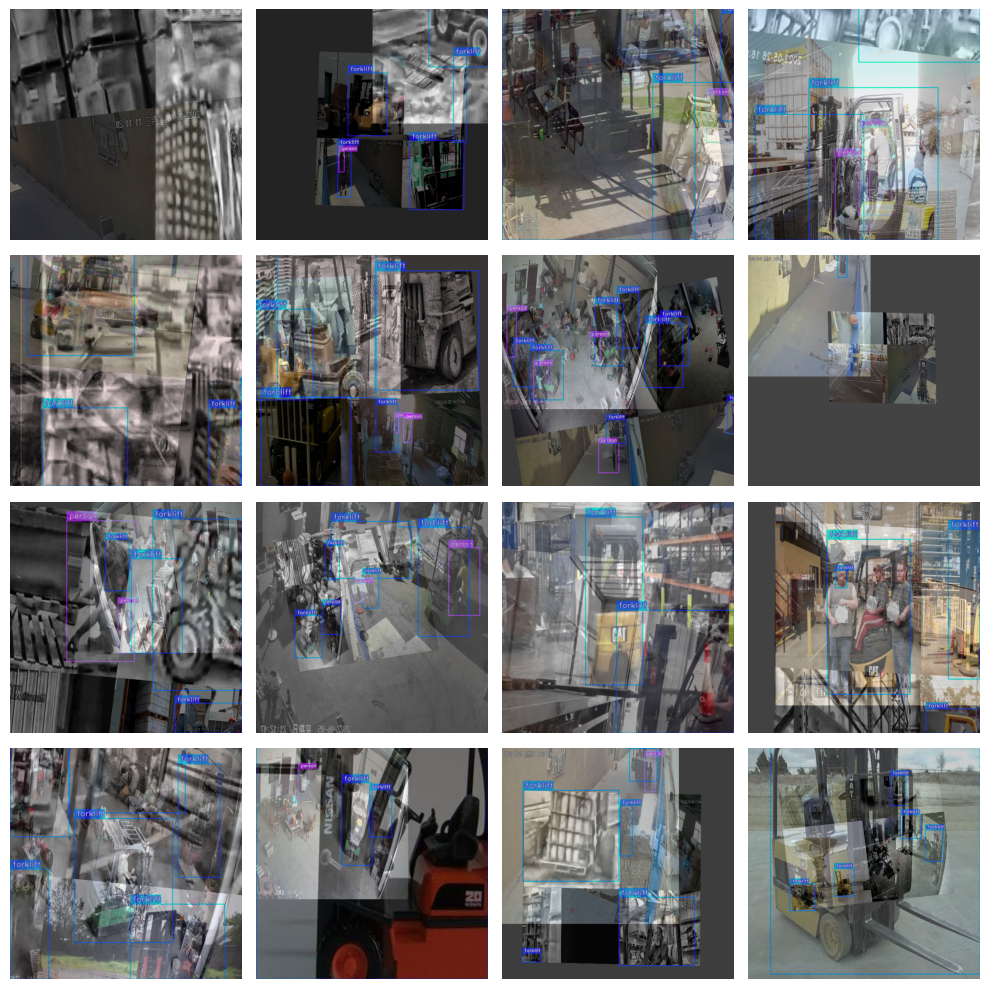

In [17]:
# Inspect Transformations Applied to Training Data
print("Transformations applied to training data:")
print(train_data.dataset.transforms)

# Visualize a Few Samples from Training Data
print("\nVisualizing samples from training data:")
train_data.dataset.plot()

# Model preparation

In [18]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)

[2024-10-04 09:36:24] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-10-04 09:36:24] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 320MB/s]
[2024-10-04 09:36:25] INFO - checkpoi

In [23]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 2,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs


In [24]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-10-04 09:37:11] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241004_093711_630067`
[2024-10-04 09:37:11] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yolonas_run/RUN_20241004_093711_630067
[2024-10-04 09:37:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


The console stream is now moved to checkpoints/my_first_yolonas_run/RUN_20241004_093711_630067/console_Oct04_09_37_11.txt


[2024-10-04 09:37:13] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3284       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         410        (len(train_loader))
    - Gradient updates per epoch:   410        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.13K parameters), WD: 0.0001, (18.98M parameters)

[2024-10-04 09:37:13] INFO - sg_trainer.py - Started training for 2

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9641
│   ├── Ppyoloeloss/loss_iou = 0.8528
│   ├── Ppyoloeloss/loss_dfl = 0.924
│   └── Ppyoloeloss/loss = 3.7409
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0079
    ├── Ppyoloeloss/loss_iou = 0.614
    ├── Ppyoloeloss/loss_dfl = 0.756
    ├── Ppyoloeloss/loss = 3.378
    ├── Precision@0.50 = 0.0702
    ├── Recall@0.50 = 0.0086
    ├── Map@0.50 = 0.0266
    ├── F1@0.50 = 0.0154
    └── Best_score_threshold = 0.06



Validating epoch 1: 100%|██████████| 125/125 [00:25<00:00,  4.99it/s]
[2024-10-04 09:47:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/RUN_20241004_093711_630067/ckpt_best.pth
[2024-10-04 09:47:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5126693844795227


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2499
│   │   ├── Epoch N-1      = 1.9641 (↘ -0.7143)
│   │   └── Best until now = 1.9641 (↘ -0.7143)
│   ├── Ppyoloeloss/loss_iou = 0.6292
│   │   ├── Epoch N-1      = 0.8528 (↘ -0.2236)
│   │   └── Best until now = 0.8528 (↘ -0.2236)
│   ├── Ppyoloeloss/loss_dfl = 0.7503
│   │   ├── Epoch N-1      = 0.924  (↘ -0.1736)
│   │   └── Best until now = 0.924  (↘ -0.1736)
│   └── Ppyoloeloss/loss = 2.6294
│       ├── Epoch N-1      = 3.7409 (↘ -1.1114)
│       └── Best until now = 3.7409 (↘ -1.1114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2087
    │   ├── Epoch N-1      = 2.0079 (↘ -0.7992)
    │   └── Best until now = 2.0079 (↘ -0.7992)
    ├── Ppyoloeloss/loss_iou = 0.5221
    │   ├── Epoch N-1      = 0.614  (↘ -0.0919)
    │   └── Best until now = 0.614  (↘ -0.0919)
    ├── Ppyoloeloss/loss_dfl = 0.6634
    │   ├── Epoch N-1      = 0.756  (↘ -0.0926)
    │   └── Best until now = 0.756  (↘ -0.0926)
    ├── Ppyoloeloss/lo

[2024-10-04 09:47:10] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Validating epoch 2:  99%|█████████▉| 124/125 [00:2

In [28]:
checkpoints_base_dir = "/content/checkpoints/my_first_yolonas_run"
checkpoint_dirs = [d for d in os.listdir(checkpoints_base_dir) if os.path.isdir(os.path.join(checkpoints_base_dir, d))]
checkpoint_dirs.sort()
latest_checkpoint_dir = checkpoint_dirs[-1]

latest_checkpoint_path = os.path.join(checkpoints_base_dir, latest_checkpoint_dir, 'ckpt_best.pth')

In [29]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=latest_checkpoint_path)

best_model.to(device)

YoloNAS_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [30]:

trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))


Testing:  98%|█████████▊| 40/41 [00:10<00:00,  5.23it/s]

{'PPYoloELoss/loss_cls': 1.1318209,
 'PPYoloELoss/loss_iou': 0.51032794,
 'PPYoloELoss/loss_dfl': 0.64670885,
 'PPYoloELoss/loss': 2.288858,
 'Precision@0.50': 0.012556541711091995,
 'Recall@0.50': 0.8839994668960571,
 'mAP@0.50': 0.5746543407440186,
 'F1@0.50': 0.0247605349868536,
 'Best_score_threshold': 0.38999998569488525}

Testing: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


# Eval

In [40]:
# Path to your COCO validation images
coco_val_directory = '/content/YoloNAS_Project/merged_dataset/images/test'

# List all jpg images in the validation directory
# Also important as on this will be based your sortings of prediction
image_paths = [os.path.join(coco_val_directory, img) for img in os.listdir(coco_val_directory) if img.endswith('.jpg')]

In [41]:

model_predictions = best_model.to(device).predict(image_paths, conf=0.20)

It seems you are using predict() with batch input
Predicting Images:   0%|          | 0/326 [00:00<?, ?it/s]`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
[2024-10-04 09:55:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
Predicting Images: 100%|██████████| 326/326 [00:04<00:00, 66.10it/s]


In [42]:
def generate_ground_truth(image_dir,label_dir, output_dir, class_mapping, input_format_truth='yolo', input_format_pred='voc'):
    """
    Converts YOLOv5 annotations and model predictions to the required format for mAP evaluation.

    Args:
        image_dir (str): Directory containing image files (e.g., JPG).
        label_dir (str): Directory containing YOLOv5 TXT label files (class_id center_x center_y width height).
                         The label files should have the same base name as the corresponding image
                         files, with the extension .txt.
        output_dir (str): Directory to save the ground-truth and detection-results files.
                          The ground-truth files will be saved in `output_dir/ground-truth/` and
                          the detection-results files will be saved in `output_dir/detection-results/`.
        class_mapping (dict): A dictionary mapping class IDs (int) to class names (str).
                              For example: {0: 'Dime', 1: 'Nickel', 2: 'Penny', 3: 'Quarter'}.
        input_format_truth (str, optional): The format of the input ground-truth bounding boxes.
                                            Default is 'yolo', assuming YOLOv5 format.
        input_format_pred (str, optional): The format of the input prediction bounding boxes.
                                           Default is 'voc', assuming VOC format.

    Returns:
        None: The function writes the converted ground-truth and detection-results files to the specified
              `output_dir` in a format compatible with the Cartucho/mAP evaluation tool.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    gt_dir = os.path.join(output_dir, 'ground-truth')
    dr_dir = os.path.join(output_dir, 'detection-results')
    os.makedirs(gt_dir, exist_ok=True)
    os.makedirs(dr_dir, exist_ok=True)


    for image_name in os.listdir(image_dir):
        if image_name.endswith('.jpg'):
            # Extract the base name without extension to find the corresponding label file
            base_name = os.path.splitext(image_name)[0]
            label_file = os.path.join(label_dir, f"{base_name}.txt")

            if not os.path.exists(label_file):
                print(f"Warning: Label file not found for image: {image_name}")
                continue

            # Load the image to get its size
            image_path = os.path.join(image_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image: {image_name}")
                continue

            image_height, image_width = image.shape[:2]
            image_size = (image_width, image_height)

            output_file = os.path.join(gt_dir, f"{base_name}.txt")

            with open(label_file, 'r') as lf, open(output_file, 'w') as of:
                for line in lf:
                    try:
                        class_id, center_x, center_y, width, height = map(float, line.strip().split())
                    except:
                        continue

                    bbox = [center_x, center_y, width, height]

                    # Convert YOLO format (center_x, center_y, width, height) to (xmin, ymin, xmax, ymax)
                    converted_bbox = pbx.convert_bbox(bbox, from_type=input_format_truth, to_type='coco', image_size=image_size)

                    xmin, ymin, w, h = converted_bbox
                    xmax = xmin + w
                    ymax = ymin + h

                    # Assuming class_id maps directly to category name
                    class_name = class_mapping[int(class_id)]

                    of.write(f"{class_name} {xmin} {ymin} {xmax} {ymax}\n")

    # Process model predictions
    for image_path, predictions in zip(image_paths, model_predictions):
        image_file = os.path.basename(image_path)

        if not os.path.exists(label_file):
            print(f"Warning: Label file not found for image: {image_name}")
            continue

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image: {image_name}")
            continue

        image_height, image_width = image.shape[:2]
        image_size = (image_width, image_height)

        output_file = os.path.join(dr_dir, image_file.replace('.jpg', '.txt'))

        with open(output_file, 'w') as f:
            for j, score in enumerate(predictions.prediction.confidence):
                category_name = predictions.class_names[predictions.prediction.labels[j]].replace(' ', '_')
                bbox = predictions.prediction.bboxes_xyxy[j]

                converted_back_bbox = pbx.convert_bbox(bbox, from_type=input_format_pred, to_type="coco", image_size=image_size)

                xmin, ymin, width, height = converted_back_bbox
                xmax = xmin + width
                ymax = ymin + height

                f.write(f"{category_name} {score} {xmin} {ymin} {xmax} {ymax}\n")


In [43]:
import cv2

In [44]:
# clean folders
!rm -r /content/mAP/input/ground-truth/
!rm -r /content/mAP/input/detection-results/
!rm -r /content/mAP/input/images-optional

rm: cannot remove '/content/mAP/input/images-optional': No such file or directory


In [45]:
# Example usage:
image_dir = '/content/YoloNAS_Project/merged_dataset/images/test'
label_dir = '/content/YoloNAS_Project/merged_dataset/labels/test'
output_dir = '/content/mAP/input'

class_mapping = {0: 'forklift', 1: 'person'}

generate_ground_truth(image_dir, label_dir, output_dir, class_mapping)

In [46]:
# Evaluate
%cd /content/
%cd mAP
!python main.py -na
%cd /content/

/content
/content/mAP
79.79% = forklift AP 
35.47% = person AP 
mAP = 57.63%


# TMP

In [ ]:
# def organize_datasets(rf_dir, merged_dir):
#     """
#     Merges multiple Roboflow datasets into a single directory with images and labels.
#     """
#     os.makedirs(merged_dir, exist_ok=True)
#     merged_images = os.path.join(merged_dir, 'images')
#     merged_labels = os.path.join(merged_dir, 'labels')
#     os.makedirs(merged_images, exist_ok=True)
#     os.makedirs(merged_labels, exist_ok=True)

#     # Function to copy files
#     def copy_files(src_images, src_labels):
#         for img_file in os.listdir(src_images):
#             if img_file.endswith(('.jpg', '.png', '.jpeg')):
#                 # Copy image
#                 src_img_path = os.path.join(src_images, img_file)
#                 dest_img_path = os.path.join(merged_images, img_file)
#                 if not os.path.exists(dest_img_path):
#                     shutil.copy(src_img_path, dest_img_path)

#                 # Copy label
#                 label_file = os.path.splitext(img_file)[0] + '.txt'
#                 src_label_path = os.path.join(src_labels, label_file)
#                 dest_label_path = os.path.join(merged_labels, label_file)
#                 if os.path.exists(src_label_path) and not os.path.exists(dest_label_path):
#                     shutil.copy(src_label_path, dest_label_path)

#     # Iterate over each Roboflow project
#     roboflow_projects = os.listdir(rf_dir)
#     for project in roboflow_projects:
#         project_dir = os.path.join(rf_dir, project)
#         for split in ['train', 'valid', 'test']:
#             split_dir = os.path.join(project_dir, split)
#             if os.path.exists(split_dir):
#                 src_images = os.path.join(split_dir, 'images')
#                 src_labels = os.path.join(split_dir, 'labels')
#                 copy_files(src_images, src_labels)

#     print(f"Datasets merged and saved to {merged_dir}")

In [ ]:
# # Define merged dataset directory
# merged_dataset_dir = os.path.join(base_dir, 'merged')

# # Organize datasets
# organize_datasets(rf_save_dir, merged_dataset_dir)

Datasets merged and saved to /content/YoloNAS_Project/merged


In [ ]:
# def create_dataset(merged_dir, dataset_params, split_ratios=(0.7, 0.2, 0.1), move_files=False):
#     """
#     Create a dataset structure for training, validation, and test sets with images and YOLO labels.

#     Parameters:
#     - merged_dir (str): Directory containing merged images and labels.
#     - dataset_params (dict): Dictionary defining the dataset structure and paths.
#     - split_ratios (tuple): Ratios for splitting the dataset into (train, valid, test).
#     - move_files (bool): Whether to move files instead of copying.
#     """
#     # Create directories for train, val, test
#     for dir_path in [dataset_params['train_images_dir'], dataset_params['train_labels_dir'],
#                      dataset_params['val_images_dir'], dataset_params['val_labels_dir'],
#                      dataset_params['test_images_dir'], dataset_params['test_labels_dir']]:
#         full_path = os.path.join(dataset_params['data_dir'], dir_path)
#         os.makedirs(full_path, exist_ok=True)

#     # Get list of image files
#     images_dir = os.path.join(merged_dir, 'images')
#     labels_dir = os.path.join(merged_dir, 'labels')
#     image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

#     # Shuffle images
#     random.seed(42)
#     random.shuffle(image_files)

#     # Split indices
#     train_end = int(len(image_files) * split_ratios[0])
#     val_end = train_end + int(len(image_files) * split_ratios[1])

#     train_files = image_files[:train_end]
#     val_files = image_files[train_end:val_end]
#     test_files = image_files[val_end:]

#     # Function to copy or move files
#     def copy_move_files(file_list, src_images, src_labels, dest_images, dest_labels):
#         for img_file in file_list:
#             src_img_path = os.path.join(src_images, img_file)
#             dest_img_path = os.path.join(dest_images, img_file)
#             src_label_path = os.path.join(src_labels, os.path.splitext(img_file)[0] + '.txt')
#             dest_label_path = os.path.join(dest_labels, os.path.splitext(img_file)[0] + '.txt')

#             # Copy or move image
#             if move_files:
#                 shutil.move(src_img_path, dest_img_path)
#             else:
#                 shutil.copy(src_img_path, dest_img_path)

#             # Copy or move label if it exists
#             if os.path.exists(src_label_path):
#                 if move_files:
#                     shutil.move(src_label_path, dest_label_path)
#                 else:
#                     shutil.copy(src_label_path, dest_label_path)
#             else:
#                 print(f"Warning: Label file does not exist for image {img_file}")

#     # Define source and destination directories
#     src_images = images_dir
#     src_labels = labels_dir

#     dest_train_images = os.path.join(dataset_params['data_dir'], dataset_params['train_images_dir'])
#     dest_train_labels = os.path.join(dataset_params['data_dir'], dataset_params['train_labels_dir'])
#     dest_val_images = os.path.join(dataset_params['data_dir'], dataset_params['val_images_dir'])
#     dest_val_labels = os.path.join(dataset_params['data_dir'], dataset_params['val_labels_dir'])
#     dest_test_images = os.path.join(dataset_params['data_dir'], dataset_params['test_images_dir'])
#     dest_test_labels = os.path.join(dataset_params['data_dir'], dataset_params['test_labels_dir'])

#     # Copy/move files
#     copy_move_files(train_files, src_images, src_labels, dest_train_images, dest_train_labels)
#     copy_move_files(val_files, src_images, src_labels, dest_val_images, dest_val_labels)
#     copy_move_files(test_files, src_images, src_labels, dest_test_images, dest_test_labels)

#     print(f"Dataset created at {dataset_params['data_dir']} with splits:")
#     print(f"Train: {len(train_files)} images")
#     print(f"Validation: {len(val_files)} images")
#     print(f"Test: {len(test_files)} images")

In [ ]:
# # Define label mapping
# label_mapping = {
#     'human': 'person'
# }

# # Standardize labels in the merged dataset
# standardize_labels(
#     merged_labels_dir=os.path.join(merged_dataset_dir, 'labels'),
#     label_mapping=label_mapping,
#     target_class_id=1  # Assuming 'person' has class ID 1
# )

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
# # Define dataset parameters
# dataset_params = {
#     'data_dir': os.path.join(base_dir, 'final_dataset'),
#     'train_images_dir': 'train/images',
#     'train_labels_dir': 'train/labels',
#     'val_images_dir': 'valid/images',
#     'val_labels_dir': 'valid/labels',
#     'test_images_dir': 'test/images',
#     'test_labels_dir': 'test/labels',
#     'classes': ['forklift', 'person']  # Update based on actual classes in your datasets
# }

# # Define split ratios
# split_ratios = (0.7, 0.2, 0.1)

# # Create dataset
# create_dataset(
#     merged_dir=merged_dataset_dir,
#     dataset_params=dataset_params,
#     split_ratios=split_ratios,
#     move_files=False  # Set to True if you want to move files instead of copying
# )

Dataset created at /content/YoloNAS_Project/final_dataset with splits:
Train: 1977 images
Validation: 565 images
Test: 283 images


In [ ]:
# def create_yaml(dataset_dir, classes):
#     """
#     Creates a dataset.yaml file for YOLO-NAS.

#     Parameters:
#     - dataset_dir (str): Base directory of the dataset containing train/val/test splits.
#     - classes (list): List of class names.
#     """
#     yaml_content = {
#         'train': os.path.join(dataset_dir, 'train/images'),
#         'val': os.path.join(dataset_dir, 'valid/images'),
#         'test': os.path.join(dataset_dir, 'test/images'),  # Optional
#         'nc': len(classes),
#         'names': classes
#     }

#     yaml_path = os.path.join(dataset_dir, 'dataset.yaml')
#     with open(yaml_path, 'w') as f:
#         yaml.dump(yaml_content, f)

#     print(f"dataset.yaml created at {yaml_path}")

In [ ]:
# Create dataset.yaml
# create_yaml(dataset_params['data_dir'], dataset_params['classes'])

NameError: name 'dataset_params' is not defined

# Dataloaders

In [3]:
# # Example usage of custom data loader functions

# train_data = coco_detection_yolo_format_train(
#     dataset_params={
#         'data_dir': dataset_params['data_dir'],
#         'images_dir': dataset_params['train_images_dir'],
#         'labels_dir': dataset_params['train_labels_dir'],
#         'classes': dataset_params['classes']
#     },
#     dataloader_params={
#         'batch_size':8,
#         'num_workers':2
#     }
# )

# val_data = coco_detection_yolo_format_val(
#     dataset_params={
#         'data_dir': dataset_params['data_dir'],
#         'images_dir': dataset_params['val_images_dir'],
#         'labels_dir': dataset_params['val_labels_dir'],
#         'classes': dataset_params['classes']
#     },
#     dataloader_params={
#         'batch_size':8,
#         'num_workers':2
#     }
# )

# test_data = coco_detection_yolo_format_val(
#     dataset_params={
#         'data_dir': dataset_params['data_dir'],
#         'images_dir': dataset_params['test_images_dir'],
#         'labels_dir': dataset_params['test_labels_dir'],
#         'classes': dataset_params['classes']
#     },
#     dataloader_params={
#         'batch_size':8,
#         'num_workers':2
#     }
# )